# Predicting employee attrition

Replacing employees is a costly task. Not only are there costs involved with recruting talented people and getting them up to speed, but **losing top talent can be a source of competitive disadvantage**. A far better alternative is to retain employees to a high degree, especially those who are highly specialized and/or exceptionally high performing. 

**What if we could reliably predict who is likely to leave the company, before it happens, and design interventions to retain them?** Here I will demonstrate buildling a prediction model desgined at identifying high flight-risk employees as well as unpacking what makes people risky in hopes to prescribe an effective retention intervention strategy.

## Dataset

For this example I utilize a public dataset from Kaggle: "IBM HR Analytics Employee Attrition & Performance". It contains information on 1470 employees, including whether each left the company, along with characteristics of each individual, indluding information about their education, job, sentiment, experience, performance, compensation, and life situation. 

In [127]:
# import packages and dataset
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv('/Users/christianclayton/Documents/Portfolio Projects/Data/IBM Attrition Data.csv')
pd.options.display.max_columns = None

In [129]:
# preview data
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Validation:

There was no missing data that needed to be dropped or filled in. A few features have the same value for all rows (standard hours, employee count, Over 18) and thus contain no useful information for our model and can be dropped. Numeric features have varying scales (sentiment features are 1-4, performance 3 or 4, while monthly income is in the tens of thosands) and amount of variance, so standardizing them to the same scale before modeling can help with interpretation and is imporant for some model types.

The target class (Attrition) is imbalanced. Only 16% of the population left in the period in question. This means that if we guessed that everyone stays rather than leaves we'd be right 84% of the time, but we'd be wrong about all the people that did leave. As we evaluate our prediction models we will want to increase that overall accuracy above 84% and importantly predict correctly when someone does leave, an accuracy metric called 'Recall'. 

In [131]:
# look at columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [133]:
# look at summary stats of numeric features
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [506]:
# look at proportion of each level in each category feature
for col in df.select_dtypes(include='object').columns:
    print("\n", df[col].value_counts(normalize = True).round(2))


 Attrition
No     0.84
Yes    0.16
Name: proportion, dtype: float64

 BusinessTravel
Travel_Rarely        0.71
Travel_Frequently    0.19
Non-Travel           0.10
Name: proportion, dtype: float64

 Department
Research & Development    0.65
Sales                     0.30
Human Resources           0.04
Name: proportion, dtype: float64

 EducationField
Life Sciences       0.41
Medical             0.32
Marketing           0.11
Technical Degree    0.09
Other               0.06
Human Resources     0.02
Name: proportion, dtype: float64

 Gender
Male      0.6
Female    0.4
Name: proportion, dtype: float64

 JobRole
Sales Executive              0.22
Research Scientist           0.20
Laboratory Technician        0.18
Manufacturing Director       0.10
Healthcare Representative    0.09
Manager                      0.07
Sales Representative         0.06
Research Director            0.05
Human Resources              0.04
Name: proportion, dtype: float64

 MaritalStatus
Married     0.46
Single      

## Exploratory analysis

In exploring how numeric features are distrubuted for leavers vs stayers we see the following is true for leavers relative to stayers... Leavers are:
- younger
- lower paid
- longer commute
- lower level
- worked for more companies
- less experience
- less tenure
- earlier in role
- earlier with current mgr
- lower sentiment on employee survey values

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


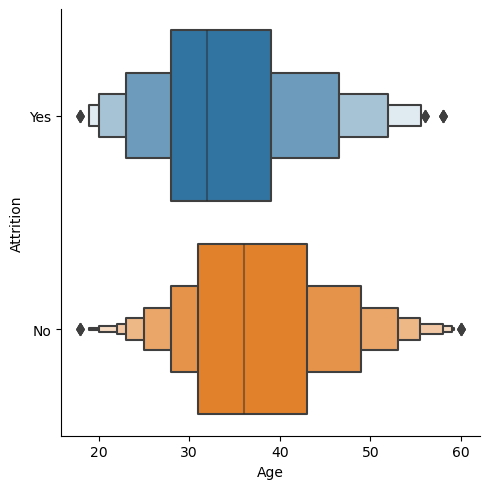

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


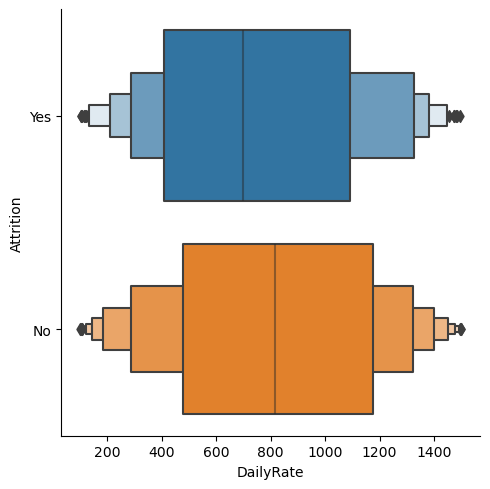

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


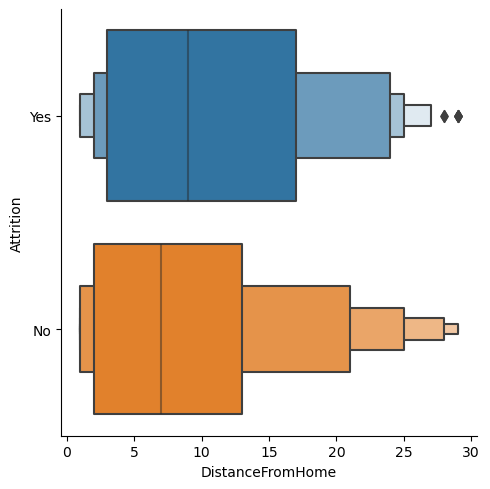

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


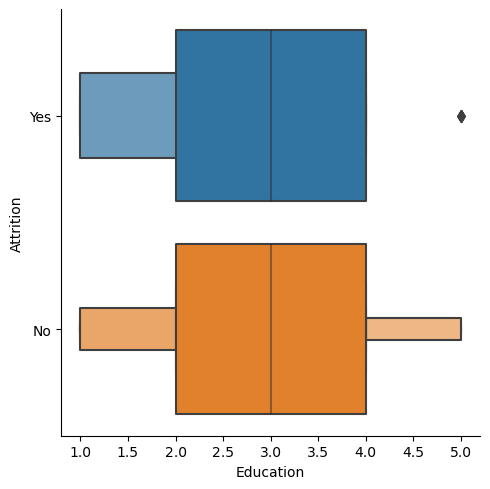

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


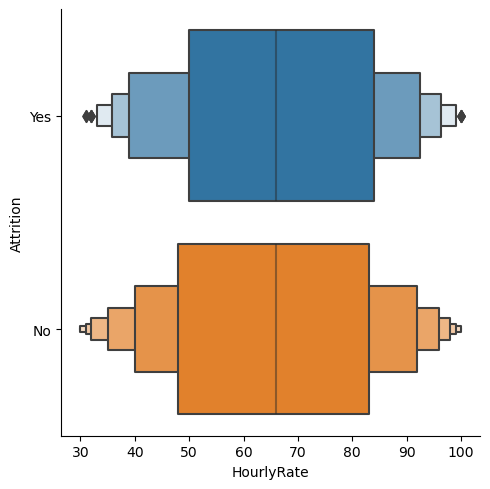

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


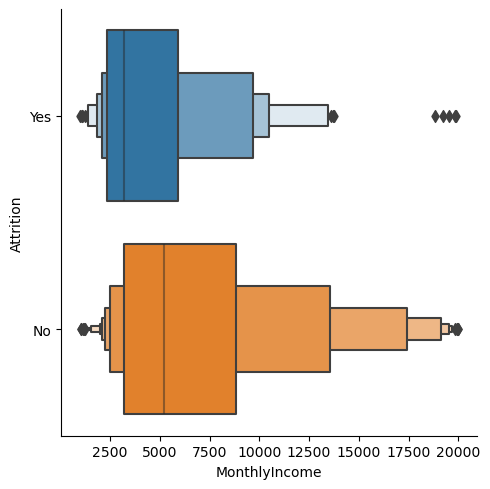

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


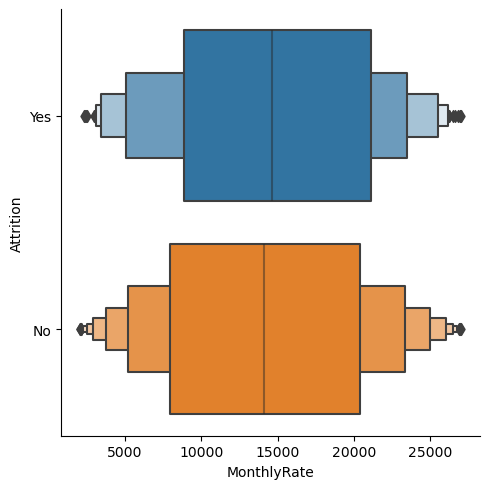

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


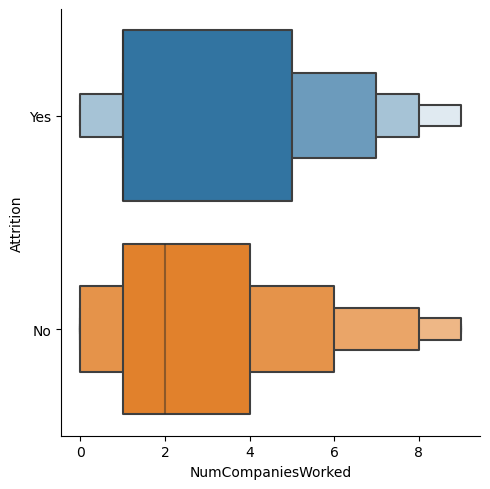

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


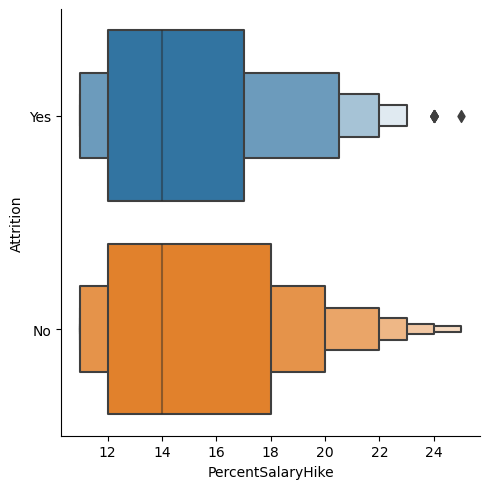

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


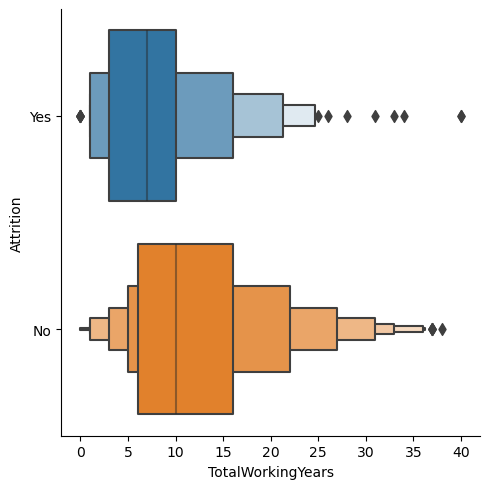

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


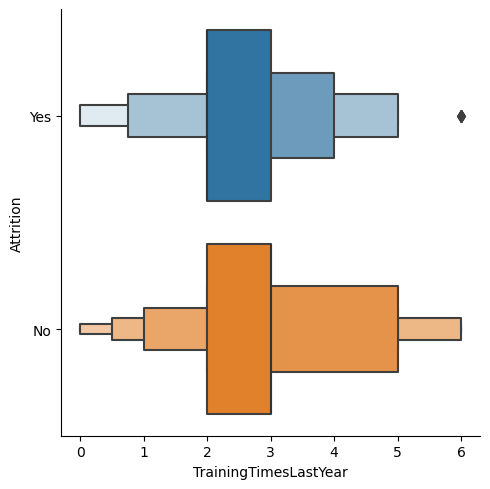

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


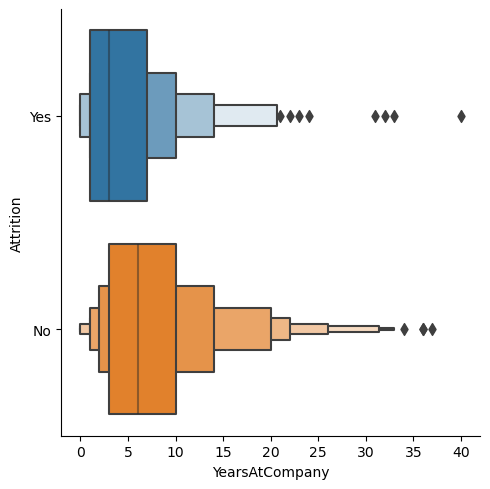

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


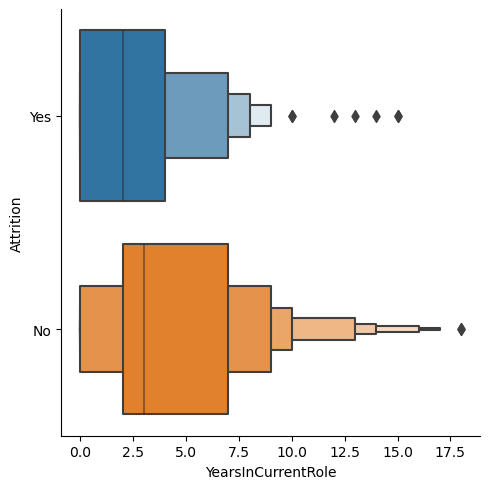

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


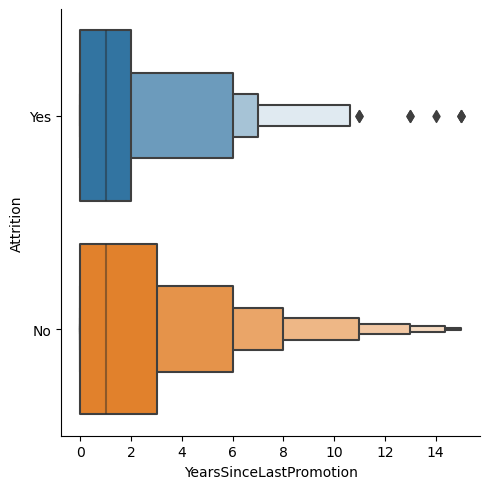

/Users/christianclayton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


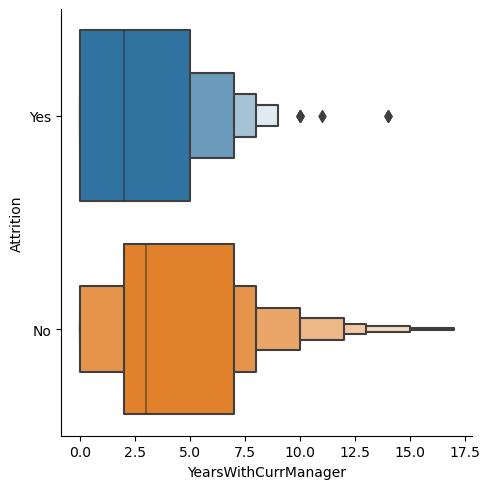

In [260]:
# view distribution of numeric features (excepting ones with very few unique values) by attrition
drop_cols = ['StandardHours','EmployeeCount','EmployeeNumber',
             'WorkLifeBalance','RelationshipSatisfaction','JobSatisfaction','JobInvolvement','EnvironmentSatisfaction',
            'PerformanceRating', 'StockOptionLevel']
num_cols = df.drop(drop_cols, axis = 1).select_dtypes(include='int64').columns
for col in num_cols:
    sns.catplot(kind = 'boxen', data = df, x = col, y = 'Attrition')
    plt.show()

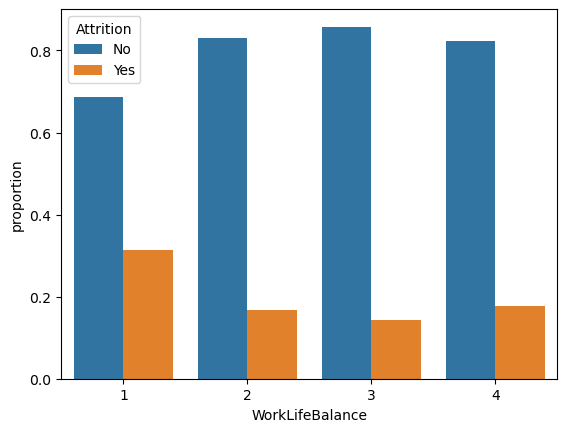

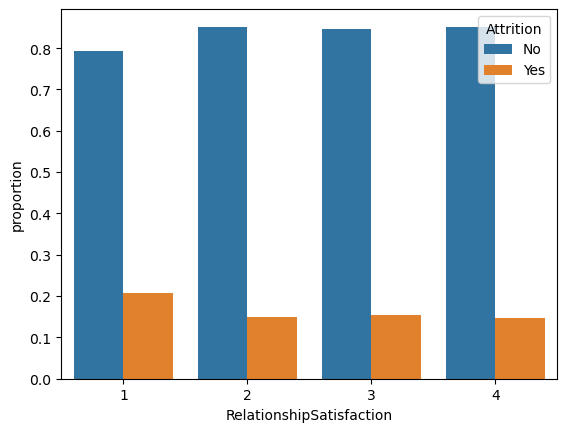

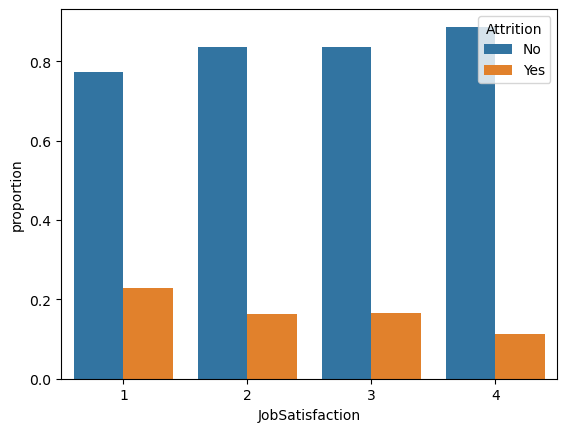

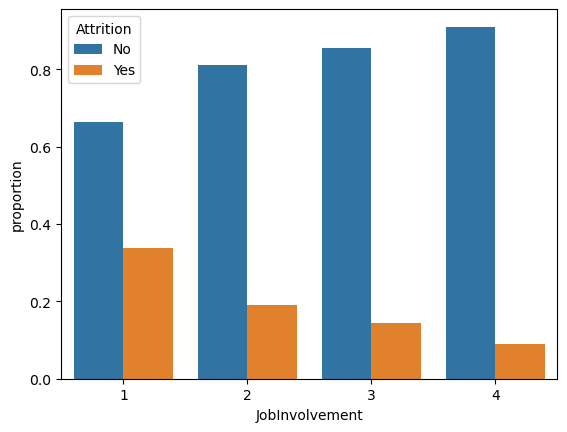

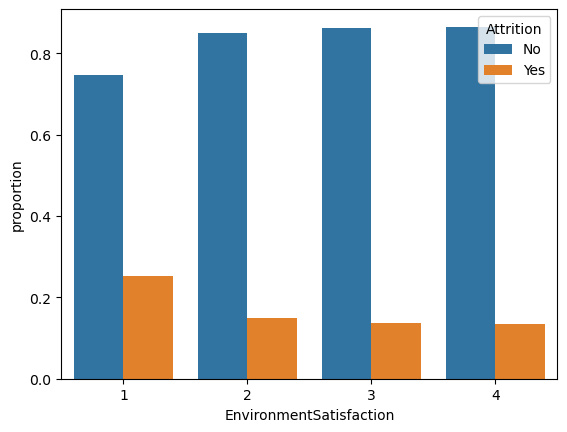

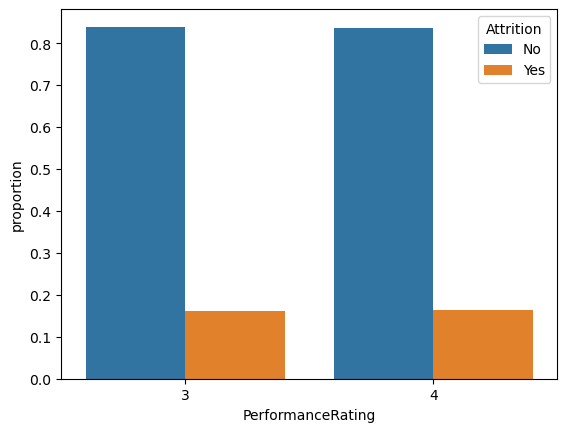

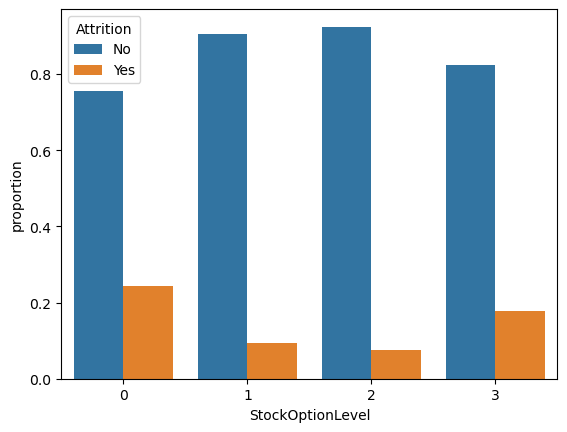

In [277]:
# view proportion of leaves in each level of ordinal variable (numeric with few unique values)
cat_cols = df[['WorkLifeBalance','RelationshipSatisfaction','JobSatisfaction','JobInvolvement','EnvironmentSatisfaction',
            'PerformanceRating', 'StockOptionLevel']].columns
for col in cat_cols:
    temp = df.groupby(col).value_counts(['Attrition'], normalize = True).reset_index()
    sns.barplot(data = temp,
            x = col,
            y = 'proportion',
            hue = 'Attrition')
    plt.show()

When we inspect the category features we find the proportion of leavers vs stayers changes quite a bit depending on the category. This indicates the feature will be useful in classifying leavers vs stayers. The following features have a lot of variance between categories and will likely be good predictors:
- business travel
- education field
- job role
- marital status
- overtime worked

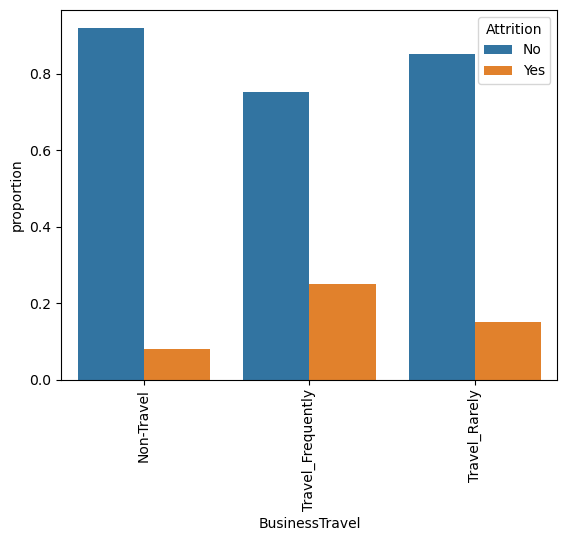

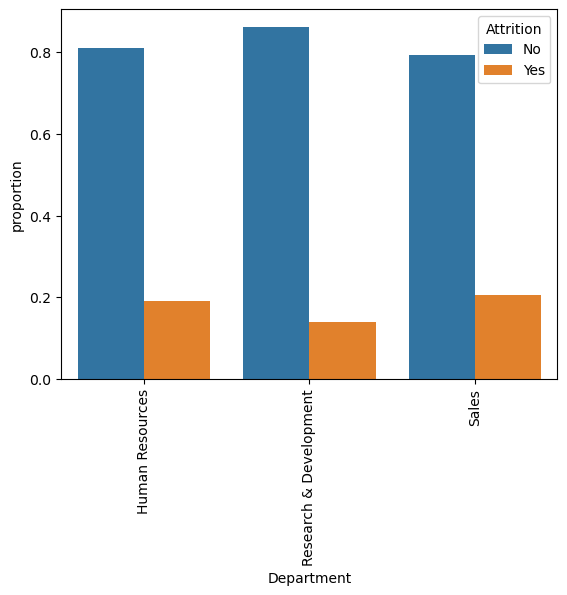

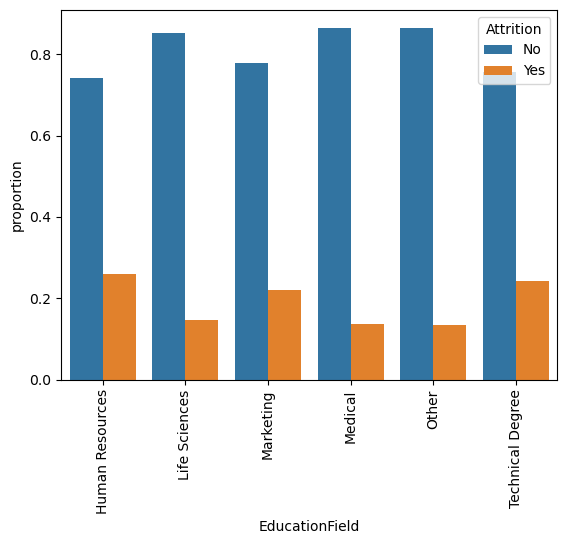

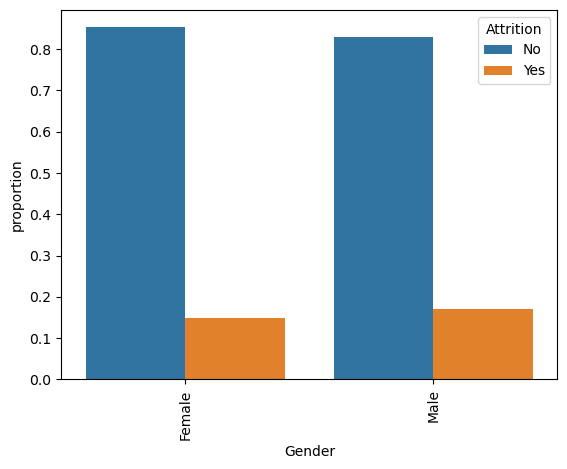

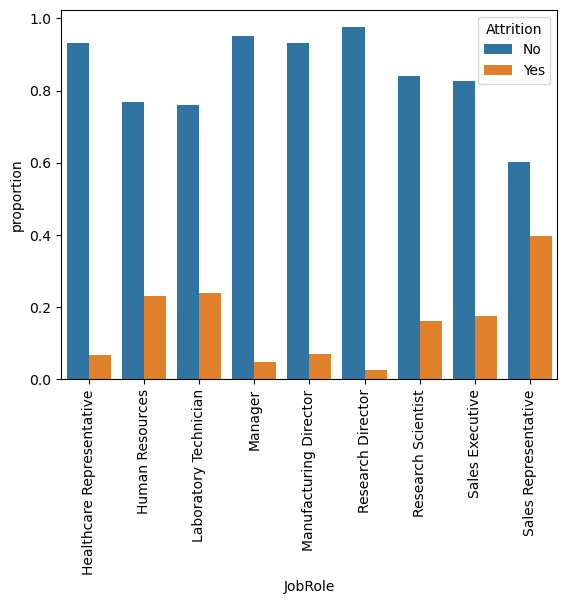

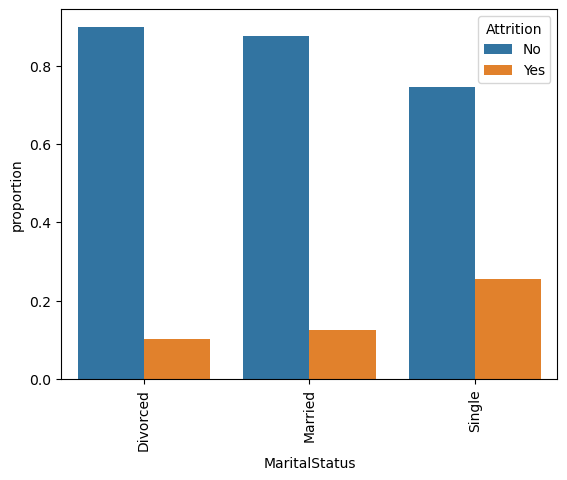

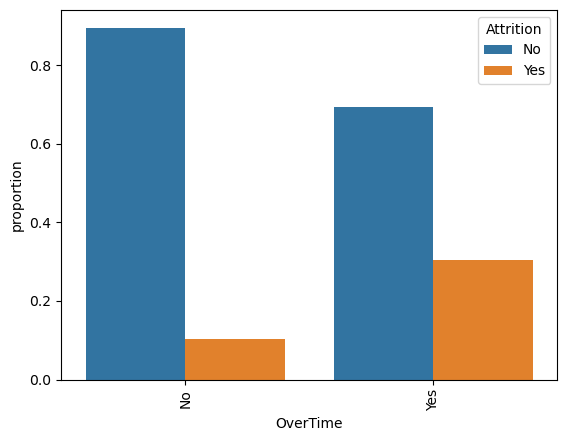

In [287]:
# view proportion of leaves in each category level of category variables
cat_cols = df.drop('Over18', axis = 1).select_dtypes(include='object').columns
cat_cols = cat_cols[cat_cols != 'Attrition']
for col in cat_cols:
    temp = df.groupby(col).value_counts(['Attrition'], normalize = True).reset_index()
    sns.barplot(data = temp,
            x = col,
            y = 'proportion',
            hue = 'Attrition')
    plt.xticks(rotation=90)
    plt.show()

Many of the features seem similar and proboably contain redundant information from the perspecitve of our attrition model.

A correlation plot of our numeric features reveals that there is a lot of correlation between features having to do with experience level (age, job level, total experience, tenure, time in role, time since promo, time with mgr). Rather than dropping I will perform principle components analysis on these features in order to preserve signal to the model from these features while reducing redundancy of information.

<Axes: >

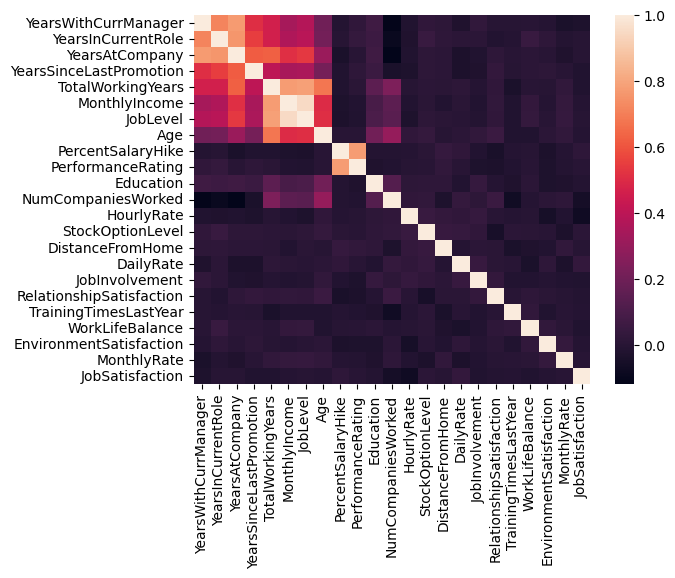

In [534]:
# function for sorting the correlation matrix
import scipy
import scipy.cluster.hierarchy as sch
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

# get correlations and sort them
corr = cluster_corr(df.drop(['Over18','StandardHours','EmployeeCount','EmployeeNumber'],axis = 1).select_dtypes(include='int64').corr())

# plot correlations in heatmap
sns.heatmap(corr)

## Principle Component Analysis
#### Reducing redundancy and noise between model features by consolidating information from many correlated features to a few uncorrelated features:

PCA of our highly correlated 'experience level' features from the correlation plot above suggests we can explain about 87% of the variance of these features with only the first 2 principle components. Adding more principle components does not add much information. In other words we can have 2 features in our model instead of 7 and we preserve 87% of the information they contain.

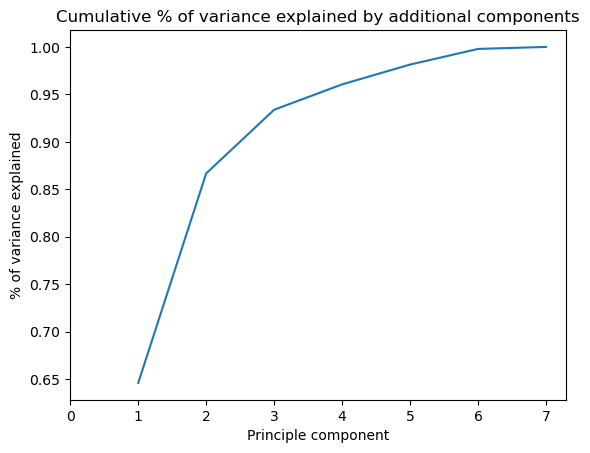

In [619]:
# check for number of significant principle components on year count/experience features
from sklearn.decomposition import PCA
pca = PCA()
experience_pca = pca.fit_transform(df[['Age','JobLevel', 'TotalWorkingYears','YearsAtCompany', 'YearsInCurrentRole',
                                'YearsSinceLastPromotion','YearsWithCurrManager']])

def cum_pca_var(n_comps, cum_exp_var_ratio):
    plt.plot(range(1,n_comps + 1), cum_exp_var_ratio)
    plt.annotate('cumulative', (n_comps + 1,1), (n_comps+ 1,.9))
    plt.xticks(range(n_comps + 1))
    plt.ylabel('% of variance explained')
    plt.xlabel('Principle component')
    plt.title('Cumulative % of variance explained by additional components')
    plt.show()

cum_pca_var(pca.n_components_, 
            pca.explained_variance_ratio_.cumsum()
           )

Because we have 4 different types of compensation features in the model it makes sense to see if we can combine them into a fewer number. PCA reveals a great candidate for reducing as 99% of the varaince in compensation features is explained by the first 2 principle components.

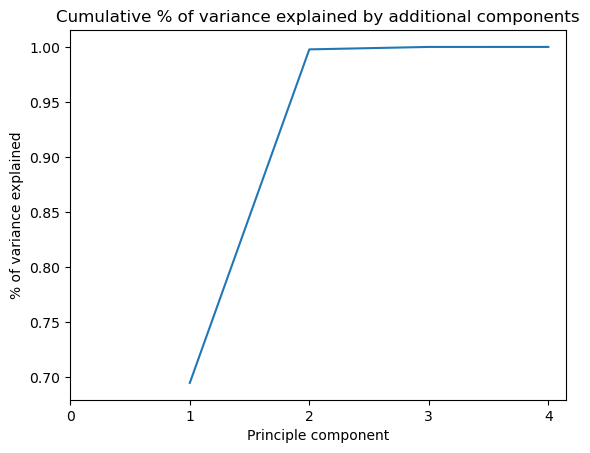

In [613]:
# check for number of significant principle components on compensation features
pca = PCA()
sent_pca = pca.fit_transform(df[['DailyRate','HourlyRate','MonthlyIncome', 'MonthlyRate']])
cum_pca_var(pca.n_components_, 
            pca.explained_variance_ratio_.cumsum()
           )

Lastly, we have 5 features that represent sentiment surveyed from an employee survey. PCA reveals the first 3 principle components of sentiment contain almost 80% of variance, 

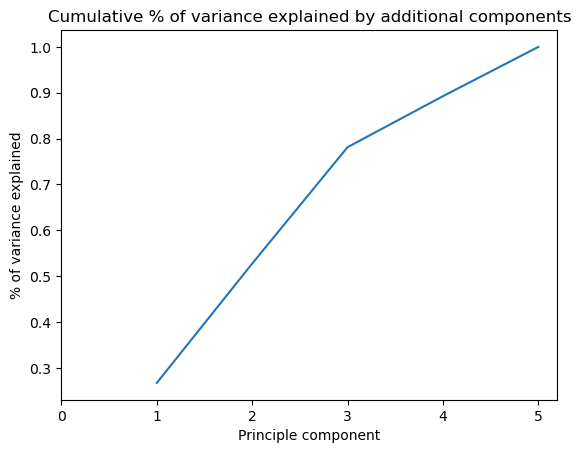

In [615]:
# check for number of significant principle components on sentiment features
pca = PCA()
sent_pca = pca.fit_transform(df[['WorkLifeBalance','RelationshipSatisfaction','JobSatisfaction',
                                 'JobInvolvement','EnvironmentSatisfaction']])
cum_pca_var(pca.n_components_, 
            pca.explained_variance_ratio_.cumsum()
           )

Overall PCA can help us go from 16 features to 7 without losing much information, hopefully decreasing model complexity and increasing predictive signal.

## Feature Engineering, Transformations, and Train/Test Split 

- get PCA features
- convert categories to dummies
- remove over18, employee count, employee number, and standard hours
- split to train and test
- standardize features

In [404]:
# get 2 principle components of the experience features
pca = PCA(n_components = 2)
experience_pca = pca.fit_transform(df[['Age','JobLevel', 'TotalWorkingYears','YearsAtCompany', 'YearsInCurrentRole',
                                'YearsSinceLastPromotion','YearsWithCurrManager']])
experience_pca = pd.DataFrame(experience_pca)
experience_pca.columns = ['Experience1', 'Experience2']

# get 2 principle components of the compensation features
pca = PCA(n_components = 2)
compensation_pca = pca.fit_transform(df[['DailyRate','HourlyRate','MonthlyIncome', 'MonthlyRate']])
compensation_pca = pd.DataFrame(compensation_pca)
compensation_pca.columns = ['Compensation1', 'Compensation2']

# get 3 principle components of the sentiment features
pca = PCA(n_components = 3)
sentiment_pca = pca.fit_transform(df[['WorkLifeBalance','RelationshipSatisfaction','JobSatisfaction',
                                 'JobInvolvement','EnvironmentSatisfaction']])
sentiment_pca = pd.DataFrame(sentiment_pca)
sentiment_pca.columns = ['Sentiment1', 'Sentiment2', 'Sentiment3']

In [418]:
# turn categorical features into 1's and 0's for sklearn to be able to interpret and use
df_cats = pd.get_dummies(df.drop(['Over18'], axis = 1).select_dtypes(include='object'), drop_first = True)

In [420]:
# combine pca features, categorical dummy features, and remaining useful numeric features
drop_cols = ['StandardHours','EmployeeCount','EmployeeNumber', 'Over18', 
             'WorkLifeBalance','RelationshipSatisfaction','JobSatisfaction','JobInvolvement','EnvironmentSatisfaction',
             'DailyRate','HourlyRate','MonthlyIncome', 'MonthlyRate',
             'Age','JobLevel', 'TotalWorkingYears','YearsAtCompany', 'YearsInCurrentRole',
             'YearsSinceLastPromotion','YearsWithCurrManager',
             'Attrition',
             'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

# combine dataframes
df2 = pd.concat([df.drop(drop_cols, axis = 1),
          df_cats,
          experience_pca,
          compensation_pca,
          sentiment_pca],
         axis = 1)

In [426]:
# split into training and test sets
from sklearn.model_selection import train_test_split
X = df2.drop('Attrition_Yes', axis = 1).values
y = df2['Attrition_Yes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, test_size = .3, stratify = y)

# standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Model Fitting and Evaluation

evaluate following model types on training CV accuracy:
- knn
- logit
- rf
- gbm

then gridsearch cv the winning model type and evaluate on test set
- random grid search cv scoring

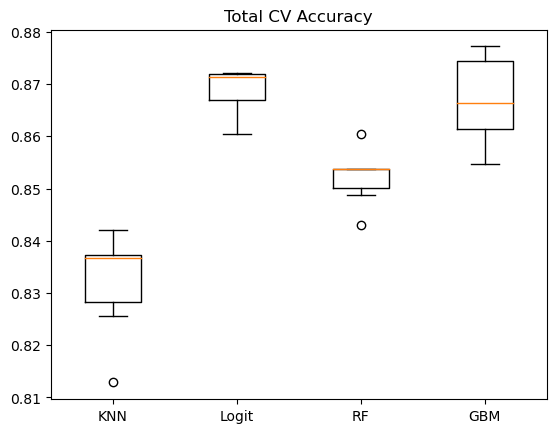

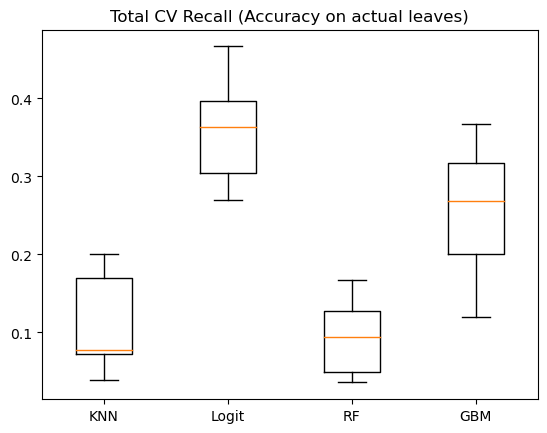

In [627]:
# get model packages
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

# set up dictionary of model types to estimate
models = {'KNN':KNeighborsClassifier(n_neighbors = 5),
          'Logit':LogisticRegression(),
          'RF':RandomForestClassifier(n_estimators = 80, min_samples_leaf = 5, random_state = 7),
          'GBM':GradientBoostingClassifier(n_estimators = 80, max_depth = 3, subsample = .8, max_features = .2, random_state = 7)}

# set up empty list to catch CV training scores
results_accuracy = []
results_recall = []

# loop through CV scoring on each model type
for model in models.values():
    kf = KFold(n_splits = 6, random_state = 7, shuffle = True)
    cv_results_accuracy = cross_val_score(model, X_train_scaled, y_train, cv = kf)
    cv_results_recall = cross_val_score(model, X_train_scaled, y_train, cv = kf, scoring = 'recall')
    results_accuracy.append(cv_results_accuracy)
    results_recall.append(cv_results_recall)

# plot cv scores
plt.boxplot(results_accuracy, labels = models.keys())
plt.title('Total CV Accuracy')
plt.show()

# plot cv scores
plt.boxplot(results_recall, labels = models.keys())
plt.title('Total CV Recall (Accuracy on actual leaves)')
plt.show()

When evaluating our four model types we use total accuracy and recall. Recall is of particular importance because it measures the accuracy on observations where employees did actually leave. Theoretically, we want the model to correctly sort between flight risks and non flight risks, however the cost of losing an employee because we didn't properly identify them as being a flight risk is probably higher than the cost of incorrectly labeling a non flight risk as a flight risk. Focusing on recall means we are prioritizing model accuracy for those that quit.

As we can see both the logit model and the gradient boosting machine perform well overall, however the logit does better at correctly identifying leavers, specifically. It should be noted that the median CV recall score is about 38%, meaning the best model type here is still only correctly classifying leavers as leavers 38% of the time, which doesn't seem excellent.

Let's see if we can tune our logit model to perform even better on recall.

In [490]:
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits = 5, shuffle = True, random_state = 7)
param_grid = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 5),
              'solver' : ['liblinear']}
logit = LogisticRegression()
logit_cv = GridSearchCV(logit, param_grid, cv = kf, scoring = 'recall')
logit_cv.fit(X_train_scaled, y_train)
print('top tuned parameters:', logit_cv.best_params_)
print('top tuned recall score:', round(logit_cv.best_score_,2))

top tuned parameters: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
top tuned recall score: 0.4


After performing a gridsearch to test out different hyperparameter combinations for the best performing model on recall, we settle in on the above hyperparameters with an average CV recall score on the training set of about 40% (a modest improvement on the base logit model).

Now let's get our best model and evaluate it on our test data the model has never seen.

In [488]:
from sklearn.metrics import recall_score
logit_best = LogisticRegression(penalty = 'l2', C = .0001, solver = 'liblinear')
logit_best.fit(X_train_scaled, y_train)
y_pred = logit_best.predict(X_test_scaled)
print('test data recall score:', round(recall_score(y_test, y_pred), 2))
print('test data overall accuracy', round(logit_best.score(X_test_scaled, y_test),2))

test data recall score: 0.38
test data overall accuracy 0.86


On test data the model has never seen our best model correctly classified leavers as leavers 38% of the time and correctly classifies all employees 86% of the time. If we look back on proportion of leavers in the overall dataset, you'll remember 84% are non-leavers, meaning our model is a modest improvement over a 'assume stay' guessing strategy in overall accuracy and a significant improvement with respect to leavers (recall).

## Interpretation

The below plot shows the magnitudes of feature influences on the odds of attrition. The way to interpret is the red bars increase attrition odds and the blue bars decrease attrition odds. For example, when an employee worked overtime that had the single biggest influence on attrition of any factor in our model and it increased odds of attrition. Some of these factors can be influenced and some cannot. For example, we cannot influence an employee to get married and we cannot magically give an employee more years of experience, but we can cap their hours so they don't work overtime and we can increase their pay.

Consequently, our model suggest the following actions could help in lowering attrition odds for an individual you hope to retain, our retention levers:
- cap hours, ensuring they do not work overtime
- pay them more
- increase their stock options
- lower the rate at which they must travel for work
- allow work from home days or pay for relocation closer to office (distance from home is probably effects of long commutes)

One factor that is puzzling is sentiment. Theoretically you'd think that higher sentiment would lower attrition odds but our model suggest the opposite. It should be noted that these are independent effects, meaning that this is sentiment when you remove any negative influence that overtime work, low pay, low stock options, long commutes, traveling for work, and the specific challenges of working in a specific department or job role have on your sentiment. A follow up analysis might be useful here to figure out what is driving this dynamic.

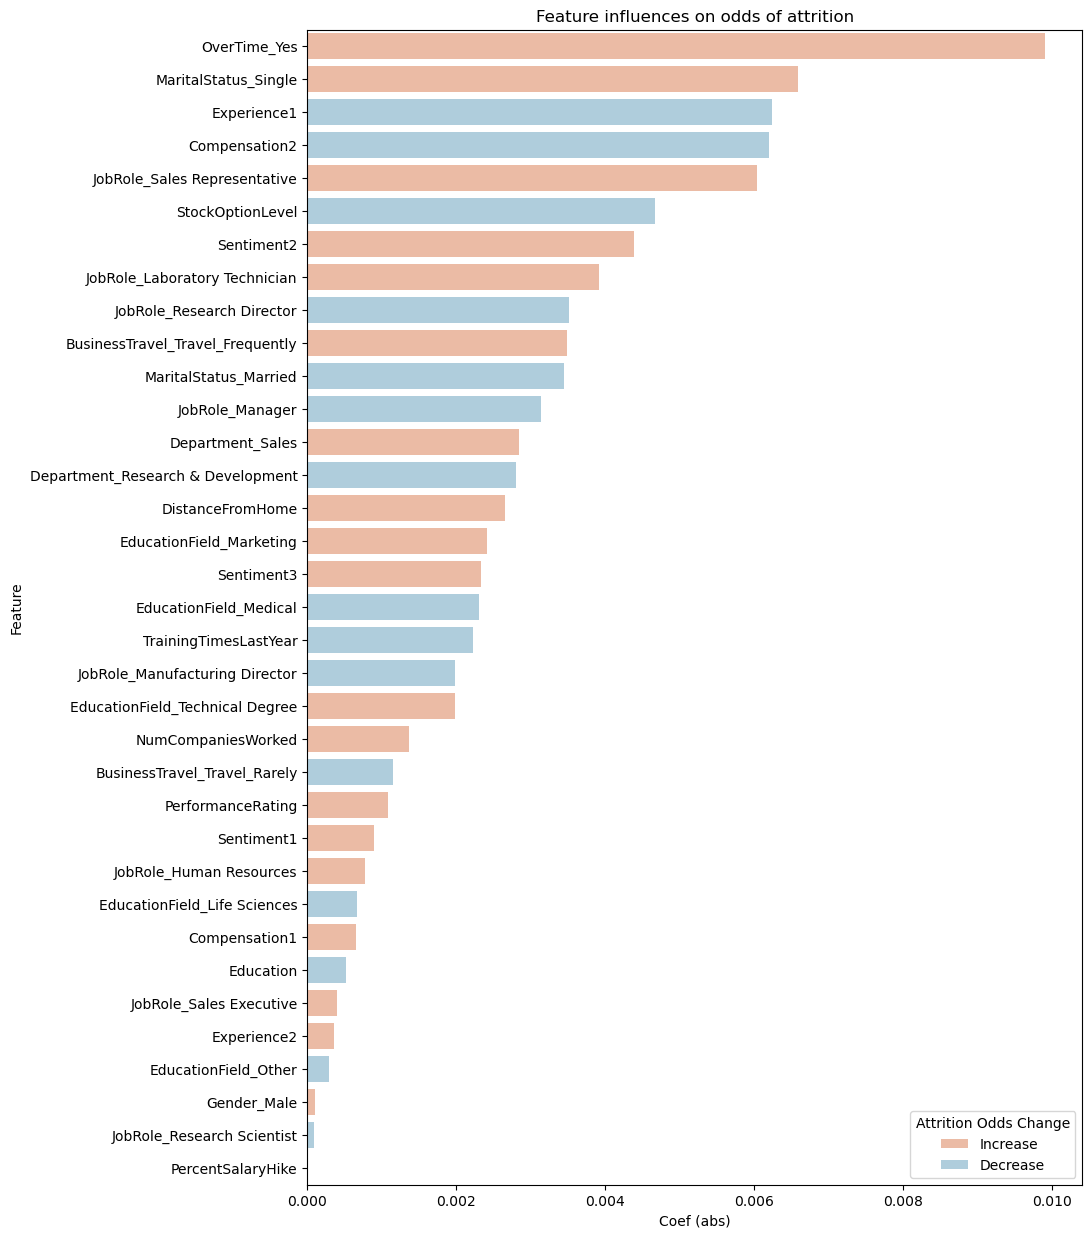

In [735]:
# inspect regression coefficients
coefs_df = pd.DataFrame({'Feature':list(df2.drop('Attrition_Yes', axis = 1).columns),
            'Coef':logit_best.coef_[0]}).sort_values('Coef',ascending = False)
coefs_df['Coef (abs)'] = coefs_df['Coef'].abs()
coefs_df = coefs_df.sort_values('Coef (abs)', ascending = False)
coefs_df['Attrition Odds Change'] = np.where(coefs_df['Coef'] < 0, 'Decrease','Increase')

plt.rcParams['figure.figsize'] = [10, 15]
sns.barplot(data = coefs_df, x = 'Coef (abs)', y = 'Feature', hue = 'Attrition Odds Change', dodge = False, palette = 'RdBu')
plt.title('Feature influences on odds of attrition')
plt.show()

## Potential Use Case

In the end, our attrition model's goal is to help us identify risks and suggest ways to mitigate them.

The below is an example of how one might use the model predictions and model coefficients to identify individuals to retain and then suggest possible retention intervention strategies. The interactive plot below uses the training and test data, but a similar tool could be built around current employees, using the model we just trained and tested on past data to get leave probabilities for currently active employees.

Below I've stratified employees along dimensions which group them in buckets with the hardest to replace employees grouped together (higher performance, higher job level, business critical job roles) and easier to replace employees grouped together (lower performance, lower job level, less critical job roles). The way to loose the tool is to identify the group of employees you want to look at and then see which employees have high leave probabilities. Hovering over a single employee will show in the tooltip their specific characteristics in terms of things we have some amount of control over changing (overtime, pay, stock options, travel requirements, commute distance) which we established in our logistic regression model have independent relationships to leave probability.

Once we know which employees are hard to replace, which also have higher leave probabilities than we are comfortable with, we can determine what retention levers we might pull. For example, if overtime = yes, then a great place to start is to look into cubring or capping their hours worked. If their salary is low relative to peers, we can look at an increase to slighly above peers. Stock options, limiting travel, and offering work from home days could also be applicable.

It should be noted that our model is observational, not necessarily causal. That is, attrition risk is related to overtime work but we don't know for certain that chaning overtime work with reduce attrition. None of the observations in our dataset (to our knowledge) contained values that were altered in order to reduce attrtion, they all came about in 'natural' ways, without interventions like we are suggesting. We can plug in new numbers to our model and see the attrition risk lower, but we will only know how causal the relationship is with an actual experiment.

Consequently, once we've identified a retention opportunity and a retention strategy, we should keep track of any interventions carried out in order to test their effectiveness. In a large organization it would be helpful to be strategic in terms of pulling single levers vs a combination of levers and the sample size of each intervention type so that we can be certain which levers work or what combination of levers works with a reasonable amount of certainty.

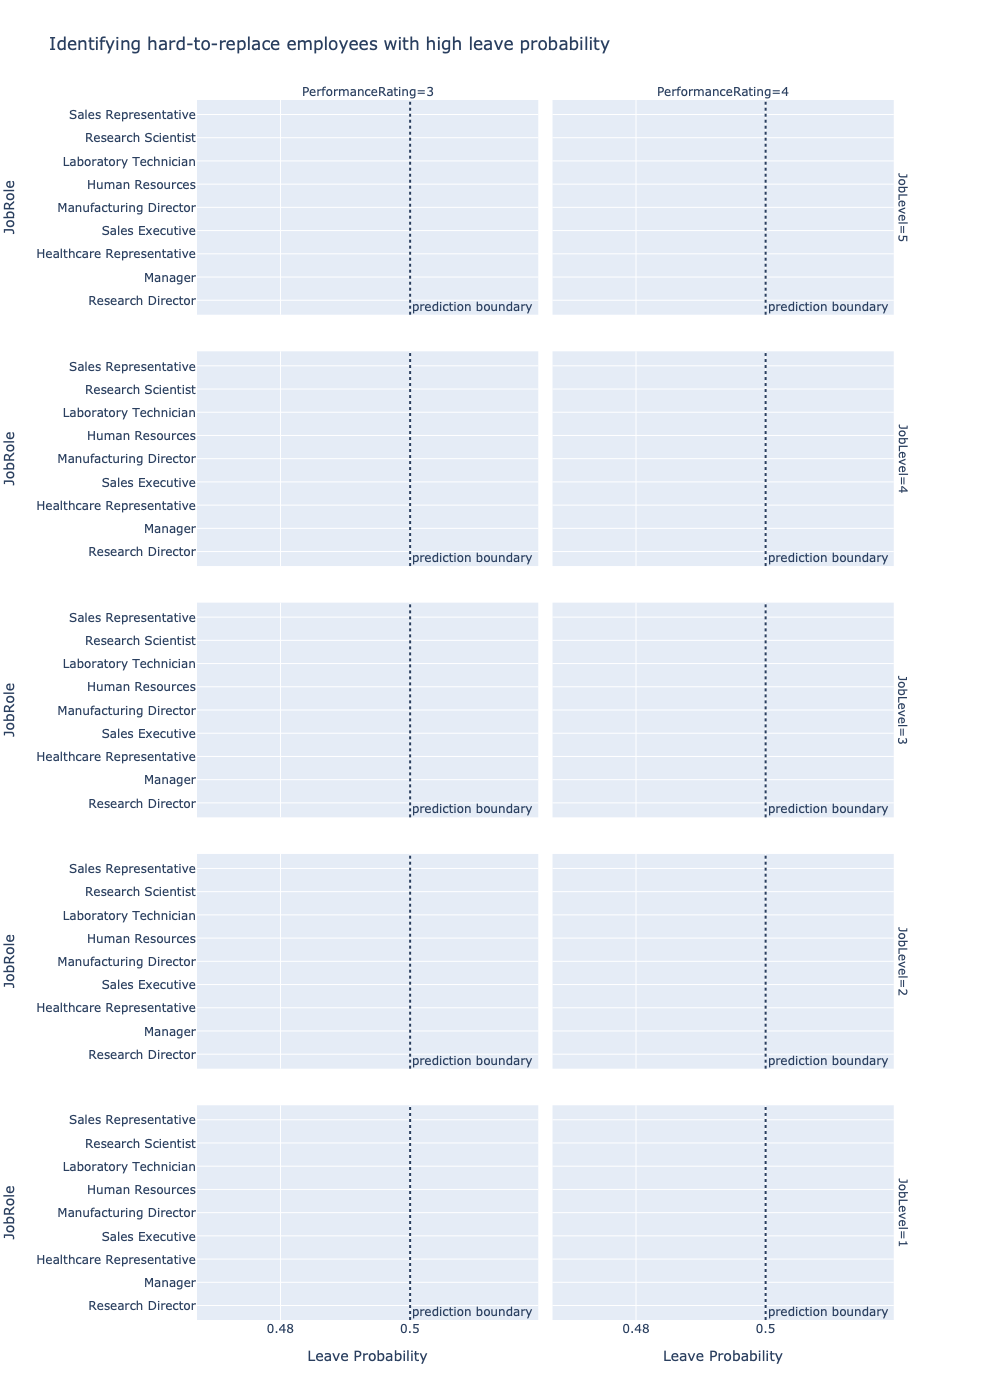

In [1055]:
# get predicted attrition probabilities
y_pred_proba = pd.concat(
    [pd.DataFrame(logit_best.predict_proba(X_test_scaled)), 
     pd.DataFrame(logit_best.predict_proba(X_train_scaled))]
)

# get original columns
X = df.drop('Attrition', axis = 1).values
y = df['Attrition'].values
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, random_state = 7, test_size = .3, stratify = y)

# set up new dataframe with original columns and add predicted quit probabilities
pred_df = pd.concat(
    [pd.DataFrame(X_test_orig),
    pd.DataFrame(X_train_orig)]
)
pred_df = pd.concat([pd.DataFrame(y_pred_proba), pred_df], axis = 1)
pred_df.columns = ['Stay Probability', 'Leave Probability'] + list(df.drop('Attrition', axis = 1).columns)
pred_df['Prediction'] = np.where(pred_df['Leave Probability'] >= .5, 'Leave', 'Stay')

# visualize probleave against hard to replace characteristics
import plotly.express as px
fig = px.scatter(pred_df, 
                 x='Leave Probability', 
                 y="JobRole", 
                 color='Leave Probability', 
                 color_continuous_scale='Bluered',
                 facet_col="PerformanceRating",
                 facet_row='JobLevel',
                 width=1000, height=1400,
                 category_orders={"JobLevel": [5,4,3,2,1]},
                 title = 'Identifying hard-to-replace employees with high leave probability',
                 hover_data = {'Prediction':False, 'PerformanceRating':False, 'JobRole':False, 'JobLevel':False,
                              'EmployeeNumber':True, 'Leave Probability':False, 'OverTime':True, 'YearlySalary':True,
                             'StockOptionLevel':True, 'BusinessTravel':True,'DistanceFromHome':True})
fig.add_vline(x = .5, annotation_text="prediction boundary", annotation_position="bottom right" ,
              line_dash = 'dot')
fig.update_layout(coloraxis_showscale=False)
fig.show()